# Tutorial 3: Diffusion Models

In this tutorial, we explore diffusion models, a class of popular generative models that have seen significant success in generating high-quality images, audio, and other data types.
We will cover the basic concepts behind diffusion models, how they work, and provide a simple implementation using Python and PyTorch.

In [1]:
# Import necessary libraries
import math
import torch
from torch import nn, Tensor
import numpy as np
import matplotlib.pyplot as plt
import sklearn.datasets as datasets

torch.manual_seed(42)
torch.set_default_dtype(torch.float64)

## Part 1: Denoising Diffusion Probabilistic Models

Let $x_0\sim p_{\text{data}} \in \mathbb{R}^d$ be a data sampled from the data distribution.
A diffusion model consists of two processes: a forward diffusion process that gradually adds noise to the data,
and a reverse denoising process that learns to remove the noise and recover the original data.

**Forward Process**

For Gaussian diffusion models, we construct a sequence of random variables $x_1, x_2, \ldots, x_T$:
$$
\begin{equation}
x_{t+1} = x_t + \varepsilon_t, \quad \varepsilon_t \sim \mathcal{N}(0, \sigma_t^2 I).
\tag{1}
\end{equation}
$$
This is called the *forward process*.
Let ${p_t}_{t\in[T]}$ be the distribution of $x_t$.
At a large step $T$, $p_T$ is nearly Gaussian, so we can approximately sample from it by sampling from a Gaussian distribution.

**Reverse Process**

The idea of diffusion models is to learn the reverse process that samples $x_{t-1}$ given $x_t\sim p_t$.
The denoising diffusion probabilistic model (DDPM) parameterizes the reverse process as:
$$
\begin{equation}
p(x_{t-1} \mid x_t) \approx \mathcal{N}(x_{t-1} ; \mu_{t-1}(x_t), \sigma^2_{t-1} I).
\tag{2}
\end{equation}
$$
Therefore, we just need to learn the mean function $\mu_{t-1}(x_t)$, which can be done by optimizing a regression loss:
$$
\begin{align}
\mu_{t-1}(x_t) & = \mathbb{E}[x_{t-1} \mid x_t] \\
\implies \mu_{t-1} &= \arg\min_f \mathbb{E}_{x_{t-1}, x_t} \| f(x_t) - x_{t-1} \|^2 \\
&= \arg\min_f \mathbb{E}_{x_{t-1}, \varepsilon} \| f(x_{t-1} + \varepsilon) - x_{t-1} \|^2.
\end{align}
$$
We sample iteratively:
$$
\begin{equation}
x_{t-1} = \mu_{t-1}(x_t) + \sigma_{t-1} \varepsilon_{t-1}, \quad \varepsilon_{t-1} \sim \mathcal{N}(0, I).
\tag{3}
\end{equation}
$$

**Discretization**

Think of the sequence $p_0, p_1, \dots, p_T$ as a discretization of a continuous-time function $p(x,t)$
that starts at the target distribution $p_0=p_{\text{data}}$ at time $t=0$ and ends at teh noisy distribution $p_T$ at time $t=1$, and:
$$
\begin{equation}
p(x, k \Delta t) = p_k(x), \quad k\in[T], \Delta t = \frac1T.
\tag{4}
\end{equation}
$$
Suppose that $x_t = x_{t-1} + \mathcal{N}(0, \sigma_t^2 I)$, then $x_T \sim \mathcal{N}(w_0, T\sigma^2 I)$.
Let $\sigma_q^2$ be the desired terminal variance, we can set $\sigma_t^2 = \sigma_q^2\Delta t$ for all $t$.

**Variance Reduction**

Observe that
$$
\begin{equation}
\mathbb{E}[x_t - x_{t-\Delta t} \mid x_t ]
= \mathbb{E} \left[ \sum_{i < t} \varepsilon_i \mid x_t \right]
= \sum_{i < t} \mathbb{E} \left[ \varepsilon_i \mid x_t \right]
= \frac{t}{\Delta t} \mathbb{E} \left[ \varepsilon_{t-\Delta t} \mid x_t \right].
\tag{5}
\end{equation}
$$
Therefore, we have the relationship:
$$
\begin{equation}
\mathbb{E} [x_{t-\Delta t} \mid x_t] = \frac{\Delta t}{t} \mathbb{E}[x_0 \mid x_t] + \left(1- \frac{\Delta t}{t}\right) x_t.
\tag{6}
\end{equation}
$$
This suggests that instead of predicting $x_{t-\Delta t}$, we can predict $x_0$ directly from $x_t$, and sample iteratively via:
$$
\begin{equation}
x_{t-\Delta t} =x_t + \frac{\Delta t}{t} \Big( \hat{x}_0(x_t) - x_t \Big) + \sigma_{t-\Delta t} \varepsilon_{t-\Delta t}, \quad \varepsilon_{t-\Delta t} \sim \mathcal{N}(0, I).
\tag{7}
\end{equation}
$$

**Noise Scheduling**

The noise schedule $\sigma_t$ plays a crucial role in the performance of diffusion models.
A common choice is to use a linear or cosine schedule, where the noise level decreases gradually over time.
This allows the model to learn to denoise effectively at different noise levels.
We reformulate the forward process as:
$$
\begin{equation}
q(x_{t} \mid x_{t-1}) = \mathcal{N}(x_{t} ; \sqrt{1-\beta_t} x_{t-1}, \beta_t I),
\tag{8}
\end{equation}
$$
where $\beta_t$ is a small positive constant that controls the amount of noise added at each step. Let $\alpha_t = 1 - \beta_t$ and $\bar{\alpha}_t = \prod_{s=1}^t \alpha_s$.
Then, we have the closed-form expression:
$$
\begin{equation}
q(x_t \mid x_0) = \mathcal{N}(x_t ; \sqrt{\bar{\alpha}_t} x_0, (1-\bar{\alpha}_t) I).
\tag{9}
\end{equation}
$$
This allows us to sample $x_t$ directly from $x_0$ without iterating through all previous steps.
We can thereby compute the forward process posteriors as:
$$
\begin{equation}
p(x_{t-1} \mid x_t, x_0) = \mathcal{N}(x_{t-1} ;
\underbrace{ \frac{\sqrt{\bar{\alpha}_{t-1}}\beta_t}{1-\bar{\alpha}_t}x_0+\frac{\sqrt{\alpha_t}(1-\bar{\alpha}_{t-1})}{1-\bar{\alpha}_t}x_t }_{\tilde{\mu}_t(x_t, x_0)},
\underbrace{ \frac{1-\bar{\alpha}_{t-1}}{1-\bar{\alpha}_t}\beta_t }_{\tilde{\beta}_t} I).
\tag{10}
\end{equation}
$$
Similar to before, we can train a model to predict the mean function $\tilde{\mu}_t(x_t, x_0)$ by optimizing the regression loss:
$$
\begin{align}
\mathcal{L}_{t-1}(\theta)
&= \mathbb{E} \Big[ \Big\| \tilde{\mu}_{t-1}(x_t) - \mu_\theta(x_t, x_0) \Big\|^2 \Big] \\
&= \mathbb{E}_{x_0, \varepsilon} \Big[ \Big\| \tilde{\mu}_t\big(x_t(x_0,\varepsilon), \frac1{\sqrt{\bar{\alpha_t}}}(x_t(x_0,\varepsilon)-\sqrt{1-\bar{\alpha}}\varepsilon)\big) - \mu_\theta(x_t(x_0,\varepsilon),t) \Big\|^2 \Big].
\tag{11}
\end{align}
$$
However, our model input is actually $x_t$ and $t$, so we instead predict the noise $\varepsilon$ added to $x_0$:

$$
\begin{equation}
\mu_\theta(x_t, t)
= \tilde{\mu}_t\Big(x_t, \frac1{\sqrt{\bar{\alpha}_t}} \big( x_t - \sqrt{1-\bar{\alpha}_t} \varepsilon_\theta(x_t, t) \Big) \Big)
= \frac1{\sqrt{\bar{\alpha}_t}} \Big( x_t - \frac{\beta_t}{\sqrt{1-\bar{\alpha}} \varepsilon_\theta(x_t, t) \Big).
\tag{12}
\end{equation}
$$

Substituting this into the loss function, we have:

$$
\begin{equation}
\mathcal{L}_{\text{DDPM}}(\theta)
= \mathbb{E}_{x_0, \varepsilon} \Big[ \Big\| \varepsilon - \varepsilon_\theta(x_t(x_0,\varepsilon), t) \Big\|^2 \Big]
= \mathbb{E}_{x_0, \varepsilon} \Big[ \Big\| \varepsilon - \varepsilon_\theta\big( \sqrt{\bar{\alpha}_t} x_0 + \sqrt{1-\bar{\alpha}_t} \varepsilon, t \big) \Big\|^2 \Big].
\tag{13}
\end{equation}
$$

This is equivalent to training the model to predict the noise $\varepsilon$ added to $x_0$ at each time step $t$.
During the reverse process, the sample is generated iteratively using the predicted noise:

$$
\begin{equation}
x_{t-1} = \frac1{\sqrt{\alpha_t}} \Big( x_t - \frac{1-\alpha_t}{\sqrt{1-\bar{\alpha}_t}} \varepsilon_\theta(x_t, t) \Big) + \sqrt{\tilde{\beta}_t} \varepsilon_{t-1}, \quad \varepsilon_{t-1} \sim \mathcal{N}(0, I).
\tag{14}
\end{equation}
$$

In [2]:
# Define the DDPM model
class DDPM(nn.Module):
    def __init__(self, model: nn.Module, dim: int, T: int = 1000) -> None:
        super().__init__()

        self.net = model
        self.dim = dim
        self.T = T

        # DDPM constants
        self.beta = torch.linspace(1e-4, 0.02, T)
        self.alpha = 1.0 - self.beta
        self.alpha_bar = torch.cumprod(self.alpha, dim=0)
        self.sqrt_1_alpha = 1.0 / torch.sqrt(self.alpha)
        self.sqrt_alpha_bar = torch.sqrt(self.alpha_bar)
        self.sqrt_1_alpha_bar = torch.sqrt(1.0 - self.alpha_bar)
        self.sqrt_tilde_beta = torch.zeros(T)
        self.sqrt_tilde_beta[1:] = (
            self.sqrt_1_alpha_bar[:-1]
            / self.sqrt_1_alpha_bar[1:]
            * torch.sqrt(self.beta[1:])
        )

    def forward(self, x: Tensor, t: Tensor) -> Tensor:
        if t.dim() == 1:
            t = t.unsqueeze(-1)
        # Concatenate time step to input
        x_t = torch.cat([x, t], dim=-1)
        return self.net(x_t)

    def training_step(self, x0: Tensor) -> Tensor:
        t = torch.randint(
            0, self.T, (x0.size(0),), device=x0.device
        )  # Random time step
        epsilon = torch.randn_like(x0)  # Sample noise

        # Generate noisy data, Equation (9)
        xt = (
            self.sqrt_alpha_bar[t].view(-1, 1).to(x0) * x0
            + self.sqrt_1_alpha_bar[t].view(-1, 1).to(x0) * epsilon
        )

        # Predict the noise
        epsilon_hat = self.forward(xt, 1.0 * t.to(xt) / self.T)

        # Compute loss
        loss = nn.MSELoss()(epsilon_hat, epsilon)
        return loss


def ddpm_sample(
    model: DDPM,
    n: int,
    last_only=True,
    device: torch.device = torch.get_default_device(),
) -> Tensor:
    x_t = torch.randn(n, model.dim).to(device)  # Sample from Gaussian at time T
    if not last_only:
        traces = torch.empty(model.T + 1, n, model.dim).to(device)
        traces[-1] = x_t

    for t in reversed(range(model.T)):
        t_tensor = torch.full((n, 1), t / model.T, device=device)
        epsilon_hat = model.forward(x_t, t_tensor)

        # Compute mean and variance for reverse process
        mu_t = model.sqrt_1_alpha[t] * (
            x_t - (model.beta[t] / model.sqrt_1_alpha_bar[t]) * epsilon_hat
        )
        z = torch.randn_like(x_t)

        # Equation (14), at last step no noise is added, and sqrt_tilde_beta[0] = 0
        x_t = mu_t + model.sqrt_tilde_beta[t] * z

        if not last_only:
            traces[t] = x_t

    return x_t if last_only else traces

Training loop.

In [3]:
def training_loop(
    model,
    data: Tensor,
    epochs: int = 1000,
    batch_size: int = 64,
    device: torch.device = torch.device("cpu"),
    **kwargs,
) -> None:
    model.to(device)
    optimizer = torch.optim.Adam(model.parameters(), **kwargs)

    dataset = torch.utils.data.TensorDataset(data)
    dataloader = torch.utils.data.DataLoader(
        dataset, batch_size=batch_size, shuffle=True
    )

    for epoch in range(epochs):
        for batch in dataloader:
            x0 = batch[0].to(device)
            loss = model.training_step(x0)

            optimizer.zero_grad()
            loss.backward()
            optimizer.step()

        if (epoch + 1) % 100 == 0:
            print(f"Epoch [{epoch + 1}/{epochs}], Loss: {loss.item():.4f}")

We train the DDPM model on a simple 2D dataset (e.g., moon) and visualize the generated samples.

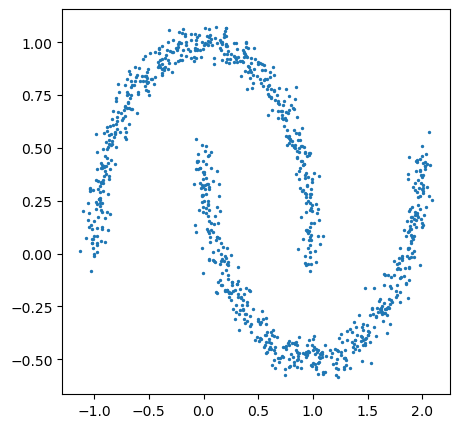

In [4]:
moons, _ = datasets.make_moons(
    n_samples=1000, noise=0.05
)  # We don't care the category labels for now

plt.figure(figsize=(5, 5))
plt.scatter(moons[:, 0], moons[:, 1], s=2)
plt.show()

Epoch [100/1000], Loss: 0.4244
Epoch [200/1000], Loss: 0.5181
Epoch [300/1000], Loss: 0.7819
Epoch [400/1000], Loss: 0.5062
Epoch [500/1000], Loss: 0.5906
Epoch [600/1000], Loss: 0.5450
Epoch [700/1000], Loss: 0.4457
Epoch [800/1000], Loss: 0.4245
Epoch [900/1000], Loss: 0.5400
Epoch [1000/1000], Loss: 0.3810


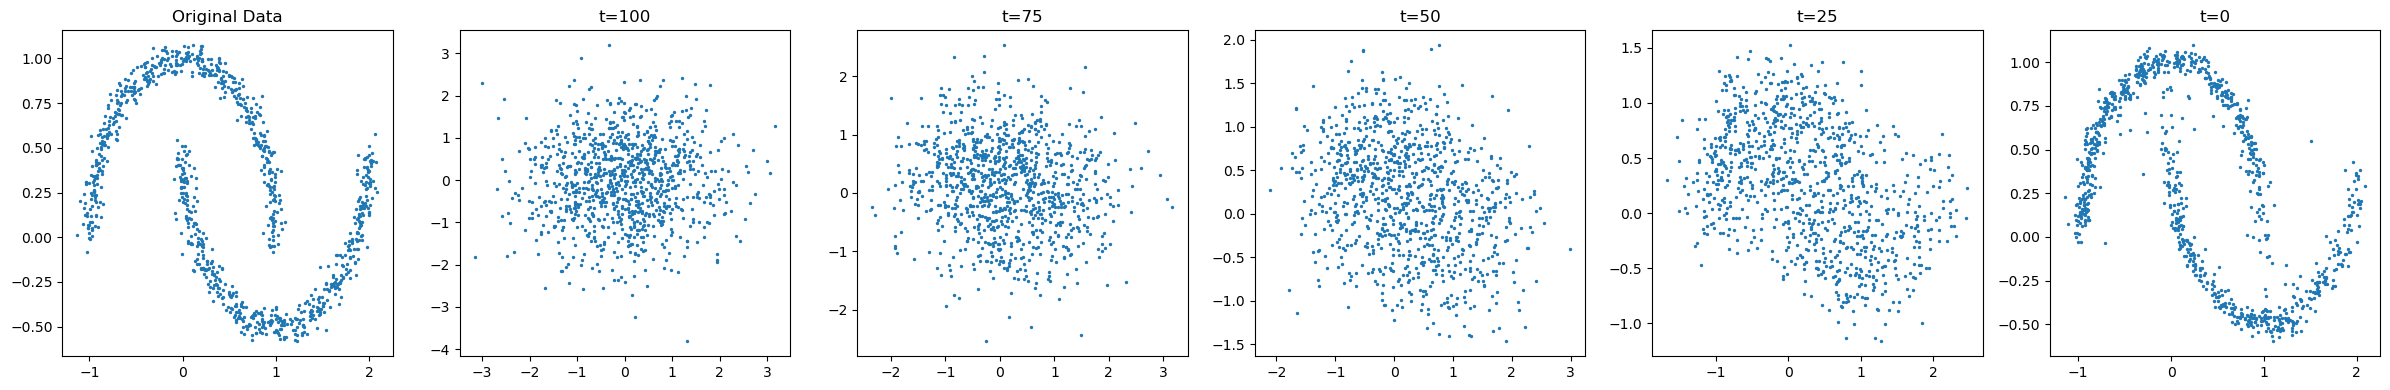

In [5]:
net = nn.Sequential(
    nn.Linear(3, 128), nn.ReLU(), nn.Linear(128, 128), nn.ReLU(), nn.Linear(128, 2)
)
ddpm_model = DDPM(model=net, dim=2, T=100)

training_loop(ddpm_model, torch.from_numpy(moons))

ddpm_samples = ddpm_sample(ddpm_model, 1000, last_only=False).detach().numpy()

fig, ax = plt.subplots(1, 6, figsize=(24, 4))
ax[0].scatter(moons[:, 0], moons[:, 1], s=2)
ax[0].set_title("Original Data")
ax[1].scatter(ddpm_samples[-1, :, 0], ddpm_samples[-1, :, 1], s=2)
ax[1].set_title("t=100")
ax[2].scatter(ddpm_samples[75, :, 0], ddpm_samples[75, :, 1], s=2)
ax[2].set_title("t=75")
ax[3].scatter(ddpm_samples[50, :, 0], ddpm_samples[50, :, 1], s=2)
ax[3].set_title("t=50")
ax[4].scatter(ddpm_samples[25, :, 0], ddpm_samples[25, :, 1], s=2)
ax[4].set_title("t=25")
ax[5].scatter(ddpm_samples[0, :, 0], ddpm_samples[0, :, 1], s=2)
ax[5].set_title("t=0")
plt.tight_layout()
plt.show()

## Part 2: Deterministic Reverse Sampler and Accelerated Sampling

While DDPM samples via a slow, stochastic Markov chain, DDIM reuses the same trained model to enable a non-Markovian, and often deterministic, reverse process that significantly accelerates sampling.

Let $\sigma_t^2 = \tilde{\beta}_t = \frac{1-\bar{\alpha}_{t-1}}{1-\bar{\alpha}_t}\beta_t$, and reorganize Equation (14):
$$
\begin{equation}
x_{t-1} =
\sqrt{\bar{\alpha}_{t-1}} \underbrace{\Big( \frac{x_t - \sqrt{1-\bar{\alpha}_t} \varepsilon_\theta(x_t, t)}{\sqrt{\bar{\alpha}_t}} \Big)}_{\text{predicted }x_0} +
\underbrace{\sqrt{1-\bar{\alpha}_{t-1} - \sigma_t^2} \varepsilon_\theta(x_t, t)}_{\text{direction pointing to } x_t} +
\sigma_t \varepsilon_{t-1}, \quad \varepsilon_{t-1} \sim \mathcal{N}(0, I).
\tag{15}
\end{equation}
$$
Let $\sigma_t^2 = 0$ in Equation (15), we obtain the deterministic DDIM sampler:
$$
\begin{equation}
x_{t-1} = \sqrt{\bar{\alpha}_{t-1}} \Big( \frac{x_t - \sqrt{1-\bar{\alpha}_t} \varepsilon_\theta(x_t, t)}{\sqrt{\bar{\alpha}_t}} \Big) +
\sqrt{1-\bar{\alpha}_{t-1}} \varepsilon_\theta(x_t, t).
\tag{16}
\end{equation}
$$

In [6]:
def ddim_sample(
    model: DDPM,
    n: int,
    last_only=True,
    device: torch.device = torch.get_default_device(),
) -> Tensor:
    x_t = torch.randn(n, model.dim).to(device)  # Sample from Gaussian at time T
    if not last_only:
        traces = torch.empty(model.T + 1, n, model.dim).to(device)
        traces[-1] = x_t

    for t in reversed(range(model.T)):
        t_tensor = torch.full((n, 1), t / model.T, device=device)
        epsilon_hat = model.forward(x_t, t_tensor)

        # Compute predicted x0
        x0_hat = (x_t - model.sqrt_1_alpha_bar[t] * epsilon_hat) / model.sqrt_alpha_bar[
            t
        ]

        # Equation (16)
        x_t = (
            model.sqrt_alpha_bar[t - 1] * x0_hat
            + model.sqrt_1_alpha_bar[t - 1] * epsilon_hat
        )

        if not last_only:
            traces[t] = x_t

    return x_t if last_only else traces

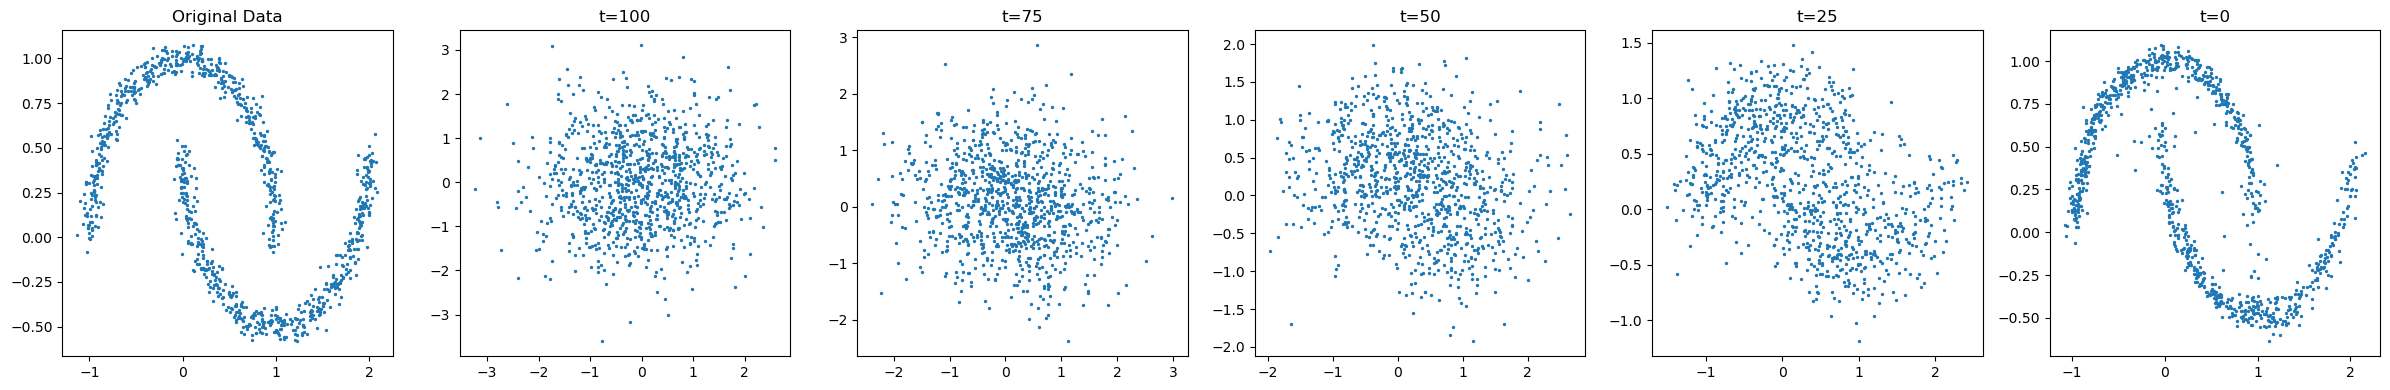

In [7]:
ddim_samples = ddpm_sample(ddpm_model, 1000, last_only=False).detach().numpy()

fig, ax = plt.subplots(1, 6, figsize=(24, 4))
ax[0].scatter(moons[:, 0], moons[:, 1], s=2)
ax[0].set_title("Original Data")
ax[1].scatter(ddim_samples[-1, :, 0], ddim_samples[-1, :, 1], s=2)
ax[1].set_title("t=100")
ax[2].scatter(ddim_samples[75, :, 0], ddim_samples[75, :, 1], s=2)
ax[2].set_title("t=75")
ax[3].scatter(ddim_samples[50, :, 0], ddim_samples[50, :, 1], s=2)
ax[3].set_title("t=50")
ax[4].scatter(ddim_samples[25, :, 0], ddim_samples[25, :, 1], s=2)
ax[4].set_title("t=25")
ax[5].scatter(ddim_samples[0, :, 0], ddim_samples[0, :, 1], s=2)
ax[5].set_title("t=0")
plt.tight_layout()
plt.show()

## Part 3: Flow-Matching Models

Flow matching models provide an alternative approach to generative modeling by learning a continuous-time flow that transforms a simple base distribution into the target data distribution.
It can be seen as a continuous generalization of DDIM.

The key concept in FM models is a time-dependent *flow* $\phi(x,t): \mathbb{R}^d \times [0,1] \to \mathbb{R}^d$ that defines a vector field over the data space.
$$
\begin{equation}
\frac{\mathop{\mathrm{d}}}{\mathop{\mathrm{d}} t} \phi(x,t) = u(\phi(x, t), t),
\tag{17}
\end{equation}
$$
where $\phi(x,1)=x\sim p_{\text{data}}$ and $u(x, t)$ is the velocity field that transports the data distribution to a simple base distribution (e.g., Gaussian) at time $t=1$.

Therefore, we can parameterize the flow using a neural network $u_\theta(x,t)$ and learn it by minimizing the expected squared error between the predicted velocity and the true velocity.
$$
\begin{equation}
\mathcal{L}_{\text{FM}}(\theta)
= \mathbb{E}_{x_0 , x_1, t} \Big\| u_\theta(x_t, t) -u_t(x_t) \Big\|^2,
\tag{18}
\end{equation}
$$
where $x_t = tx_1 + (1-t)x_0$.

However, the above loss (18) requires knowledge of the true flow $u_t(x_t)$, which is impractical in general.
We can instead condition the loss on a single target point $x_0$ and derive a tractable loss function:
$$
\begin{equation}
\mathcal{L}_{\text{CFM}}(\theta)
= \mathbb{E}_{x_0, \varepsilon, t} \Big\| u_\theta(x_t, t) - u_t(x_t \mid x_0) \Big\|^2,
\tag{19}
\end{equation}
$$
where $x_t = t x_1 + (1-t) x_0$ and $u_t(x \mid x_0)=\frac{x_0-x}{t}$.
This is called the *conditional flow matching* (CFM) loss.

> **Remark**
>
> In order to be consistent with previous notations, we set $x_0\sim p_{\text{data}}$ and $x_1\sim p_{\text{prior}}$ here.
> However, in most FM settings, $x_0$ is sampled from the prior distribution (e.g., Gaussian) and $x_1$ is sampled from the data distribution.

After training, we can generate samples by solving the ODE defined by the learned flow:
$$
\begin{equation}
\frac{\mathop{\mathrm{d}}}{\mathop{\mathrm{d}} t} x_t = u_\theta(x_t, t), \quad x_1 \sim p_{\text{prior}}.
\tag{20}
\end{equation}
$$
This can be done using standard ODE solvers, such as Euler's method, mid-point method or Runge-Kutta methods.

For simplicity, we implement the Euler method here:
$$
\begin{equation}
x_{t-\Delta t} = x_t + \Delta t \cdot u_\theta(x_t, t).
\tag{21}
\end{equation}
$$

In [8]:
class Flow(nn.Module):
    def __init__(self, model: nn.Module, dim: int) -> None:
        super().__init__()

        self.net = model
        self.dim = dim

    def forward(self, x: Tensor, t: Tensor) -> Tensor:
        if t.dim() == 1:
            t = t.unsqueeze(-1)
        # Concatenate time step to input
        x_t = torch.cat([x, t], dim=-1)
        return self.net(x_t)

    def training_step(self, x0: Tensor) -> Tensor:
        t = torch.rand(x0.size(0), 1, device=x0.device)  # Random time step in [0, 1)
        x1 = torch.randn_like(x0)  # Sample from prior distribution (standard Gaussian)

        xt = t * x1 + (1 - t) * x0  # Interpolate between x0 and x1

        ut = x0 - x1  # True velocity
        ut_hat = self.forward(xt, t)  # Predicted velocity

        loss = nn.MSELoss()(ut_hat, ut)
        return loss


def Euler_sample(
    model: Flow,
    n: int,
    steps: int = 100,
    last_only=True,
    device: torch.device = torch.get_default_device(),
) -> Tensor:
    x_t = torch.randn(
        n, model.dim, device=device
    )  # Sample from prior distribution at time t=1
    if not last_only:
        traces = torch.zeros(steps + 1, n, model.dim, device=device)
        traces[-1] = x_t

    dt = 1.0 / steps
    for step in range(steps):
        t = 1.0 - step * dt
        t_tensor = torch.full((n, 1), t, device=device)

        u_t = model.forward(x_t, t_tensor)

        # Equation (21)
        x_t = x_t + dt * u_t

        if not last_only:
            traces[steps - step - 1] = x_t

    return x_t if last_only else traces

In [9]:
net = nn.Sequential(
    nn.Linear(3, 128), nn.ReLU(), nn.Linear(128, 128), nn.ReLU(), nn.Linear(128, 2)
)
fm_model = Flow(model=net, dim=2)

training_loop(fm_model, torch.from_numpy(moons))

Epoch [100/1000], Loss: 0.9231
Epoch [200/1000], Loss: 0.8063
Epoch [300/1000], Loss: 1.4363
Epoch [400/1000], Loss: 0.7732
Epoch [500/1000], Loss: 1.2324
Epoch [600/1000], Loss: 0.9285
Epoch [700/1000], Loss: 0.8049
Epoch [800/1000], Loss: 0.9622
Epoch [900/1000], Loss: 0.7742
Epoch [1000/1000], Loss: 1.0238


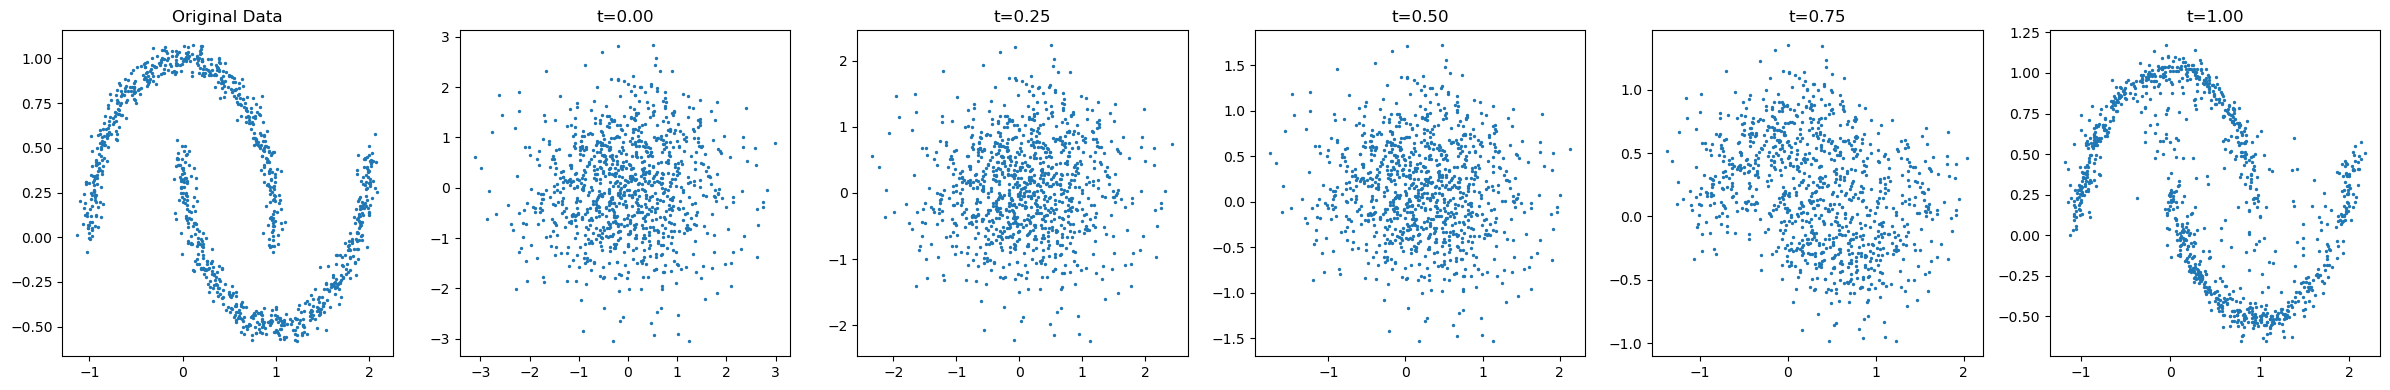

In [10]:
fm_samples = Euler_sample(fm_model, 1000, steps=100, last_only=False).detach().numpy()

fig, ax = plt.subplots(1, 6, figsize=(24, 4))
ax[0].scatter(moons[:, 0], moons[:, 1], s=2)
ax[0].set_title("Original Data")
ax[1].scatter(fm_samples[-1, :, 0], fm_samples[-1, :, 1], s=2)
ax[1].set_title("t=0.00")
ax[2].scatter(fm_samples[75, :, 0], fm_samples[75, :, 1], s=2)
ax[2].set_title("t=0.25")
ax[3].scatter(fm_samples[50, :, 0], fm_samples[50, :, 1], s=2)
ax[3].set_title("t=0.50")
ax[4].scatter(fm_samples[25, :, 0], fm_samples[25, :, 1], s=2)
ax[4].set_title("t=0.75")
ax[5].scatter(fm_samples[0, :, 0], fm_samples[0, :, 1], s=2)
ax[5].set_title("t=1.00")
plt.tight_layout()
plt.show()

## Consistency Models for One-Step Generation

Consistency models (CM) are a class of generative models that aim to learn a mapping from a simple base distribution (e.g., Gaussian) to the target data distribution in a single step.
This is achieved by training a neural network to satisfy a *consistency condition* that ensures the generated samples are consistent with the data distribution.

The consistency condition can be formulated as:
$$
\begin{equation}
f(x_t, t) = x_0, \quad \text{for all } t \in [0, 1],
\tag{22}
\end{equation}
$$
where $f(x, t)$ is the consistency function that takes a noisy input $x_t$ at time $t$ and outputs the denoised sample $x_0$.


It can be easily seen that:
$$
\begin{equation}
f(x_t, t) = x_0 \iff \frac{\mathop{\mathrm{d}}}{\mathop{\mathrm{d}} t} f(x_t, t) = 0, \quad f(x_0, 0) = x_0.
\tag{22'}
\end{equation}
$$

To enforce the consistency condition, we parameterize the consistency function as:
$$
\begin{equation}
f_\theta(x, t) = c_{\text{skip}}(t) x + c_{\text{out}}(t) \cdot F_\theta(x, t),
\tag{23}
\end{equation}
$$
where $c_{\text{skip}}(t)$ and $c_{\text{out}}(t)$ are time-dependent coefficients satisfying that $c_{\text{skip}}(0)=1$ and $c_{\text{out}}(0)=0$,
and $F_\theta(x, t)$ is a neural network that predicts the residual between the input and the output.

A common choice is:
$$
\begin{equation}
c_{\text{skip}}(t) = \sqrt{t}, \quad c_{\text{out}}(t) = \sqrt{1-t}.
\tag{23'}
\end{equation}
$$

**Training**

Let $t_\text{min}=t_1<t_2<\cdots<t_N=T$.
We can train the model by minimizing a metric between adjacent points on the sampling trajectory:
$$
\begin{equation}
\mathcal{L}_{\text{CM}}(\theta) = \mathbb{E} \Big[ w(t) d\big( f_\theta(x_{t_i+1}, t_i), f_{\theta^-}(\tilde{x}_{t_{i}}, t_{i+1}) \big) \Big],
\tag{24}
\end{equation}
$$

The above loss (24) can be approximated by
$$
\begin{equation}
\mathcal{L}_{\text{CM}}(\theta) = \mathbb{E}_{x_0, \varepsilon,t} \Big[ w(t,r) d(f_\theta(x_0 + t\varepsilon), f_{\mathop{\mathrm{sg}}(\theta)}(x_0 + r\varepsilon)) \Big],
\tag{24'}
\end{equation}
$$
as $t-r\to0$, where $t>r\ge0$.

**Sampling**

CM is able to generate samples in a single step:
$$
\begin{equation}
x_0 = f_\theta(x_T, T), \quad x_T \sim p_{\text{prior}}.
\tag{25}
\end{equation}
$$

Alternatively, one can also evaluate the consistency model multiple times by alternating denoising and noise injection steps for improved sample quality.
Iteratively:
$$
\begin{equation}
\begin{aligned}
\hat{x}_{t_{i+1}} &= \hat{x}_0^{(i)} + t_{i+1} \varepsilon_{i+1}, & \varepsilon_i \sim \mathcal{N}(0, I), \\
\hat{x}_0^{(i+1)} &= f_\theta(\hat{x}_{t_{i+1}}, t_{i+1}).
\end{aligned}
\tag{26}
\end{equation}
$$